In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import Model, Input, layers, models, Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import load_model
from PIL import UnidentifiedImageError, ImageFile
from sklearn.model_selection import train_test_split 

In [2]:
encoder_path = r'C:\Users\Student-N207\Documents\breast-cancer-dl\model\sml_final_model.keras'
decoder_path = r'C:\Users\Student-N207\Documents\breast-cancer-dl\model\decoder.keras'
DATA_DIR = "Plots"
train_interval = 600
val_interval = 700
test_interval = 700

In [3]:
def combine_encoder_decoder(encoder_path, decoder_path):
    encoder = load_model(encoder_path)
    decoder = load_model(decoder_path)

    input_shape = encoder.input_shape[1:]

    inputs = Input(shape=input_shape)

    latent_output = encoder(inputs)

    decoded_output = decoder(latent_output)
    
    full_model = Model(inputs=inputs, outputs=decoded_output, name="DualStageNetwork")

    full_model.compile(optimizer='adam', loss='binary_crossentropy')

    return full_model

In [4]:
def load_data(data_dir):
    # drive.mount('/content/drive')

    all_imgs = sorted(
        [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))],
        key=lambda x: int(''.join(filter(str.isdigit, os.path.basename(x))))
    )

    train_files = all_imgs[:train_interval]
    val_files   = all_imgs[train_interval:val_interval]
    test_files  = all_imgs[test_interval:]

    # train_files, test_files = train_test_split(all_imgs, test_size=0.3, random_state=42)
    # val_files, test_files   = train_test_split(test_files, test_size=107, random_state=42)

    # all_imgs = np.array(all_imgs)
    # indices = np.arange(len(all_imgs))

    # train_idx, temp_idx = train_test_split(indices, test_size=0.3, random_state=42)
    # val_idx, test_idx = train_test_split(temp_idx, test_size=107, random_state=42)  # 108 val, 107 test
    
    # train_files = all_imgs[train_idx]
    # val_files   = all_imgs[val_idx]
    # test_files  = all_imgs[test_idx]

    # train_idx = np.array(train_idx)
    # val_idx = np.array(val_idx)
    # test_idx = np.array(test_idx)

    # indexes = {'train': train_idx, 'val': val_idx, 'test': test_idx}

    print(f"Train: {len(train_files)}, Val: {len(val_files)}, Test: {len(test_files)}")
    return train_files, val_files, test_files

In [5]:
def load_images(file_list):
    data = []
    for f in file_list:
        try:
            img = load_img(f, target_size=(128, 128), color_mode="rgb")
            arr = img_to_array(img) / 255.0
            data.append(arr)
        except (OSError, UnidentifiedImageError) as e:
            print(f"⚠️ Skipping corrupted image: {f} ({e})")
    return np.array(data)

In [6]:
def plot_result(autoencoder, X_signal, Y_target, num_images=5):

    preds = autoencoder.predict(X_signal[:num_images])

    plt.figure(figsize=(12, 9))

    for i in range(num_images):

        # 1. Plot INPUT SIGNAL (grayscale dari channel 0)
        plt.subplot(3, num_images, i+1)
        inp = X_signal[i]

        # Normalize untuk visualisasi
        norm = (inp[...,0] - inp[...,0].min()) / (inp[...,0].max() - inp[...,0].min() + 1e-8)

        plt.imshow(norm, cmap='gray')
        plt.title("Input Signal")
        plt.axis("off")

        # 2. TARGET IMAGE
        plt.subplot(3, num_images, i+1+num_images)
        plt.imshow(Y_target[i])
        plt.title("Target Image")
        plt.axis("off")

        # 3. RECONSTRUCTED
        plt.subplot(3, num_images, i+1+2*num_images)
        plt.imshow(preds[i])
        plt.title("Reconstructed")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [7]:
def create_cnn(input_shape, latent_dim):
  model = Sequential([
      Input(shape=input_shape),
      layers.Conv2D(16, (3,3), activation='relu', strides=1),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(32, (3,3), activation='relu', strides=1),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(64, (3,3), activation='relu', strides=1),
      # layers.MaxPooling2D((2,2)),
      layers.Flatten(),
      layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
      layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
      layers.Dense(latent_dim, activation='linear')
  ])
  return model

In [8]:
def build_decoder(img_size, latent_dim):
    inputs = layers.Input(shape=(latent_dim,))

    x = layers.Dense((img_size//32) * (img_size//32) * 128, activation="relu")(inputs)
    x = layers.Reshape((img_size//32, img_size//32, 128))(x)   # 4x4x128 jika img_size=128

    x = layers.Conv2DTranspose(128, (3,3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(64, (3,3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(32, (3,3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(16, (3,3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(16, (3,3), activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(8, (3,3), strides=2, activation="relu", padding="same")(x)

    outputs = layers.Conv2D(3, (3,3), activation="sigmoid", padding="same")(x)

    return models.Model(inputs, outputs, name="Decoder")


In [9]:
train_files, val_files, test_files = load_data(DATA_DIR)
train_data = load_images(train_files)
val_data   = load_images(val_files)
test_data  = load_images(test_files)

X_signal = np.load("latent_rep/final_dataset_baru.npy")
X_signal_train = X_signal[:train_interval]
X_signal_val = X_signal[train_interval:val_interval]
X_signal_test = X_signal[test_interval:]
# X_signal_train = X_signal[indexes['train']]
# X_signal_val = X_signal[indexes['val']]
# X_signal_test = X_signal[indexes['test']]

Train: 600, Val: 100, Test: 15


In [10]:
train_data.shape

(600, 128, 128, 3)

In [11]:
val_data.shape

(100, 128, 128, 3)

In [12]:
test_data.shape

(15, 128, 128, 3)

In [13]:
X_signal_test.shape

(15, 24, 24, 2)

In [14]:
X_signal_train.shape

(600, 24, 24, 2)

In [15]:
X_signal_val.shape

(100, 24, 24, 2)

In [16]:
# encoder = create_cnn(input_shape=(24,24,2), latent_dim=256)
# decoder = build_decoder(img_size=128, latent_dim=256)

# inputs = tf.keras.Input(shape=(24,24,2))
# latent = encoder(inputs)
# outputs = decoder(latent)

# autoencoder = tf.keras.Model(inputs, outputs)
# autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [17]:
# autoencoder.fit(X_signal_train, train_data, epochs=50, batch_size=4, validation_data=(X_signal_val, val_data))

In [18]:
# import os

# path = r"C:\Users\Student-N207\Documents\project\model\sml_final_model.keras"

# print("exists:", os.path.exists(path))
# print("isfile:", os.path.isfile(path))
# print("isdir :", os.path.isdir(path))
# print("size  :", os.path.getsize(path) if os.path.exists(path) else None)

In [19]:
full_model = combine_encoder_decoder(encoder_path, decoder_path)
full_model.summary()
full_model.fit(X_signal_train, train_data, epochs=30, batch_size=2)

Model: "DualStageNetwork"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24, 24, 2)]       0         
                                                                 
 sequential (Sequential)     (None, 256)               352144    
                                                                 
 Decoder (Functional)        (None, 128, 128, 3)       4271139   
                                                                 
Total params: 4,623,283
Trainable params: 4,623,283
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
300/300 [==============================] - 12s 19ms/step - loss: 0.5232
Epoch 2/30
300/300 [==============================] - 7s 25ms/step - loss: 0.5119
Epoch 3/30
300/300 [==============================] - 6s 22ms/step - loss: 0.5102
Epoch 4/30
300/300 [==============================] - 4s 

1/1 [==============================] - 0s 246ms/step


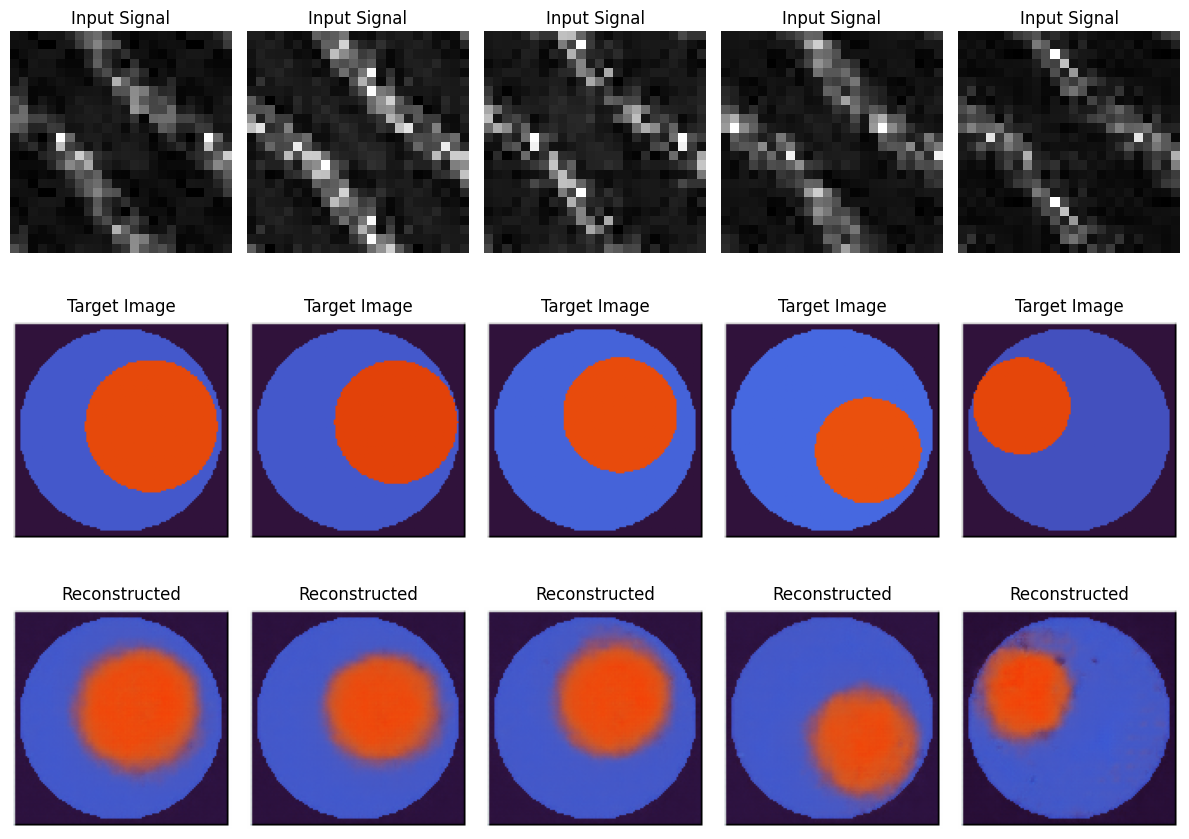

In [20]:
plot_result(full_model, X_signal_train, train_data)


1/1 [==============================] - 0s 17ms/step


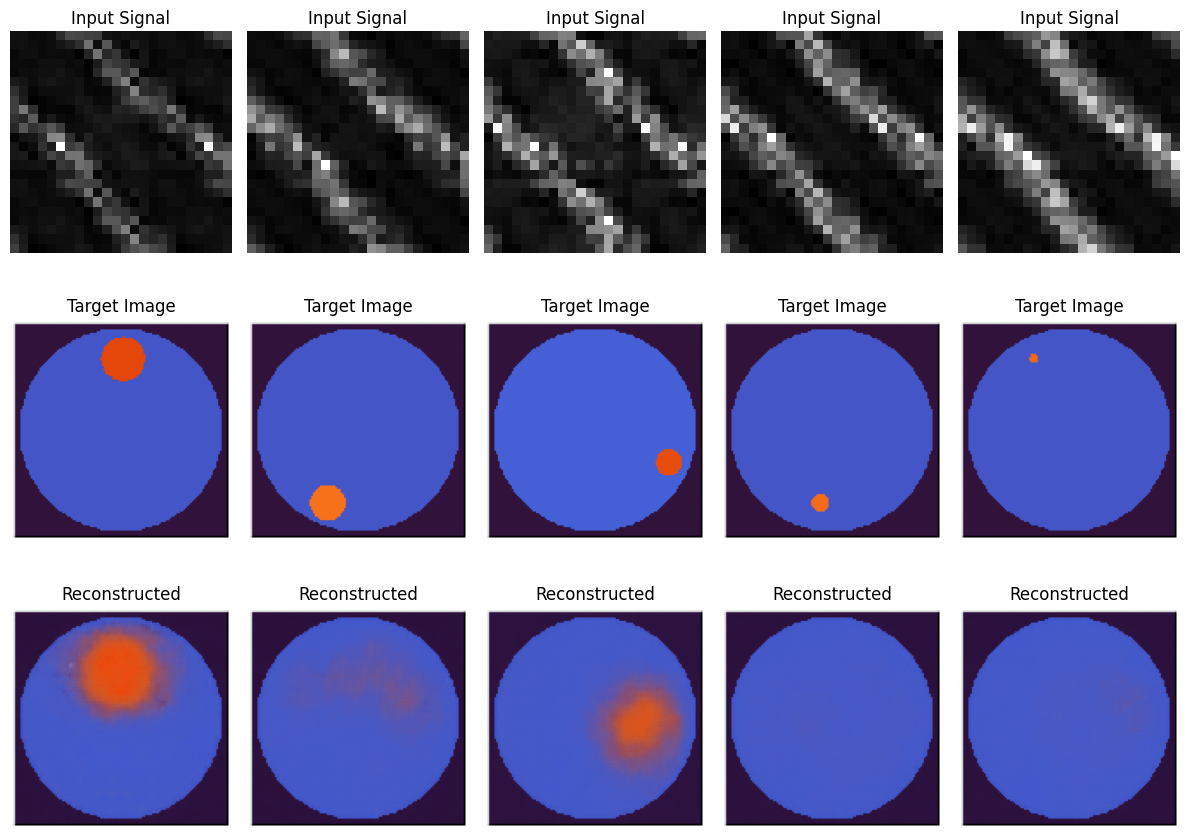

In [21]:
plot_result(full_model, X_signal_test, test_data)